In [1]:
import random
from functools import partial
from IPython.display import clear_output
from string import ascii_uppercase

import numpy as np
import einops

import matplotlib.pyplot as plt

from plotly_utils import imshow, line, scatter

import torch

from transformer_lens import HookedTransformer
from transformer_lens import utils, patching

/home/jgcarrasco/.virtualenvs/mech_interp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
# tokens of capital letters
cap_tokens = model.to_tokens([x for x in ascii_uppercase], prepend_bos=False)[:, 0]
cap_tokens_space = model.to_tokens([" " + str(x) for x in ascii_uppercase], prepend_bos=False)[:, 0]
# as we are taking a subset of the vocabulary, we also enumerate them in order 
# (e.g 'A' is the token 32, but is enumerated as 0 on the subspace, etc.)
idx_to_token = {k:v.item() for k, v in enumerate(cap_tokens)}
token_to_idx = {v.item():k for k, v in enumerate(cap_tokens)}
space_to_no_space = {k.item():v.item() for k,v in zip(cap_tokens_space, cap_tokens)}
no_space_to_space = {k.item():v.item() for k,v in zip(cap_tokens, cap_tokens_space)}


# indices of the token containing the first/second/third capital letters
indices_letters = [2, 3, 4]
# same for the acronym letter -1 (this is where the corresponding logit is stored)
indices_logits = [5, 6, 7]
# letter that we want to modify: 0, 1 or 2
letter = 2

In [4]:
with open("data/2_adv_acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

adv_letter = "A"

prompts = [prompt for prompt in prompts if adv_letter == model.to_str_tokens(prompt)[indices_letters[letter]][1]]

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = len(prompts)
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

In [5]:
tokens = model.to_tokens(prompts)
answer_tokens = model.to_tokens(acronyms, prepend_bos=False)

logits, cache = model.run_with_cache(tokens)
logits = model(tokens)

In [6]:
layer = 10
head = 10
# Map the residual stream vector into the logits of the proper tokens
z = cache[utils.get_act_name("z", layer)][:, :, head]
output = (z @ model.W_O[layer, head])[:, indices_logits[letter]]
output = model.ln_final(output)
# Unembed
output = (output @ model.W_U)[:, cap_tokens]
avg_output = output.mean(0)
std_output = output.std(0)

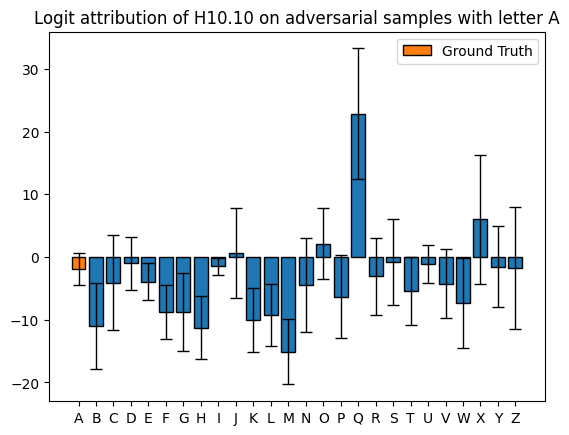

In [7]:
color = ["C1" if c == adv_letter else "C0" for c in list(ascii_uppercase)]

# Customize the error bar appearance
error_kw = dict(lw=1., capsize=4, capthick=1, ecolor='black')

plt.title(f"Logit attribution of H{layer}.{head} on adversarial samples with letter {adv_letter}")
bars = plt.bar(x=list(ascii_uppercase), height=avg_output.detach().cpu(), yerr=std_output.detach().cpu(),
        edgecolor="black", color=color, error_kw=error_kw)
# Create a legend indicating the "Ground Truth" bar

plt.legend([bars[ascii_uppercase.index(adv_letter)]], ["Ground Truth"])

plt.show()